In [53]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from mpl_toolkits.basemap import Basemap

import numpy as np
import pandas as pd

In [54]:
hdi_df = pd.read_csv("../files/hdi/hdi_with_components.csv", index_col="iso_a3")
hdi_df.head()

,country,hdi_rank,hdi,life_expectancy_at_birth,expected_years_of_schooling,mean_years_of_schooling,gni,gni_rank_minus_hdi_rank,mark
iso_a3,,,,,,,,,
NOR,Norway,1,0.944,81.6,17.5,12.6,64992,5,VH
AUS,Australia,2,0.935,82.4,20.2,13.0,42261,17,VH
CHE,Switzerland,3,0.930,83.0,15.8,12.8,56431,6,VH
DNK,Denmark,4,0.923,80.2,18.7,12.7,44025,11,VH
NLD,Netherlands,5,0.922,81.6,17.9,11.9,45435,9,VH


# HDI на карте мира

In [55]:
WATER_COLOR = "#AACBD9"
CONTINENT_COLOR = "#FFFBE7"
PATH_TO_SHAPEFILE = "../shapefiles/admin_0_countries_lakes/ne_10m_admin_0_countries_lakes"
NUM_COLORS = 10

DESCRIPTION = """
The Human Development Index (HDI) was created to emphasize that expanding human choices should be the ultimate criteria for
assessing development results. Economic growth is a mean to that process, but is not an end by itself. The HDI can also be
used to question national policy choices, asking how two countries with the same level of GNI per capita can end up with different
human development outcomes. For example, Malaysia has GNI per capita higher than Chile, but in Malaysia, life expectancy at birth is
about 7 years shorter and expected years of schooling is 2.5 years shorter than Chile, resulting in Chile having a much higher HDI value
than Malaysia. These striking contrasts can stimulate debate about government policy priorities.""".strip()

In [56]:
m = Basemap(lon_0=0, projection='robin')

In [57]:
cm = plt.get_cmap('Blues') # Blues, Greens
scheme = [cm(i / float(NUM_COLORS)) for i in range(NUM_COLORS)]

bins = np.linspace(hdi_df.hdi.min(), hdi_df.hdi.max(), NUM_COLORS)

hdi_df['bin'] = np.digitize(hdi_df.hdi, bins) - 1
hdi_df.sort('bin', ascending=False).head(2)

,country,hdi_rank,hdi,life_expectancy_at_birth,expected_years_of_schooling,mean_years_of_schooling,gni,gni_rank_minus_hdi_rank,mark,bin
iso_a3,,,,,,,,,,
NOR,Norway,1,0.944,81.6,17.5,12.6,64992,5,VH,9
SWE,Sweden,14,0.907,82.2,15.8,12.1,45636,-1,VH,8


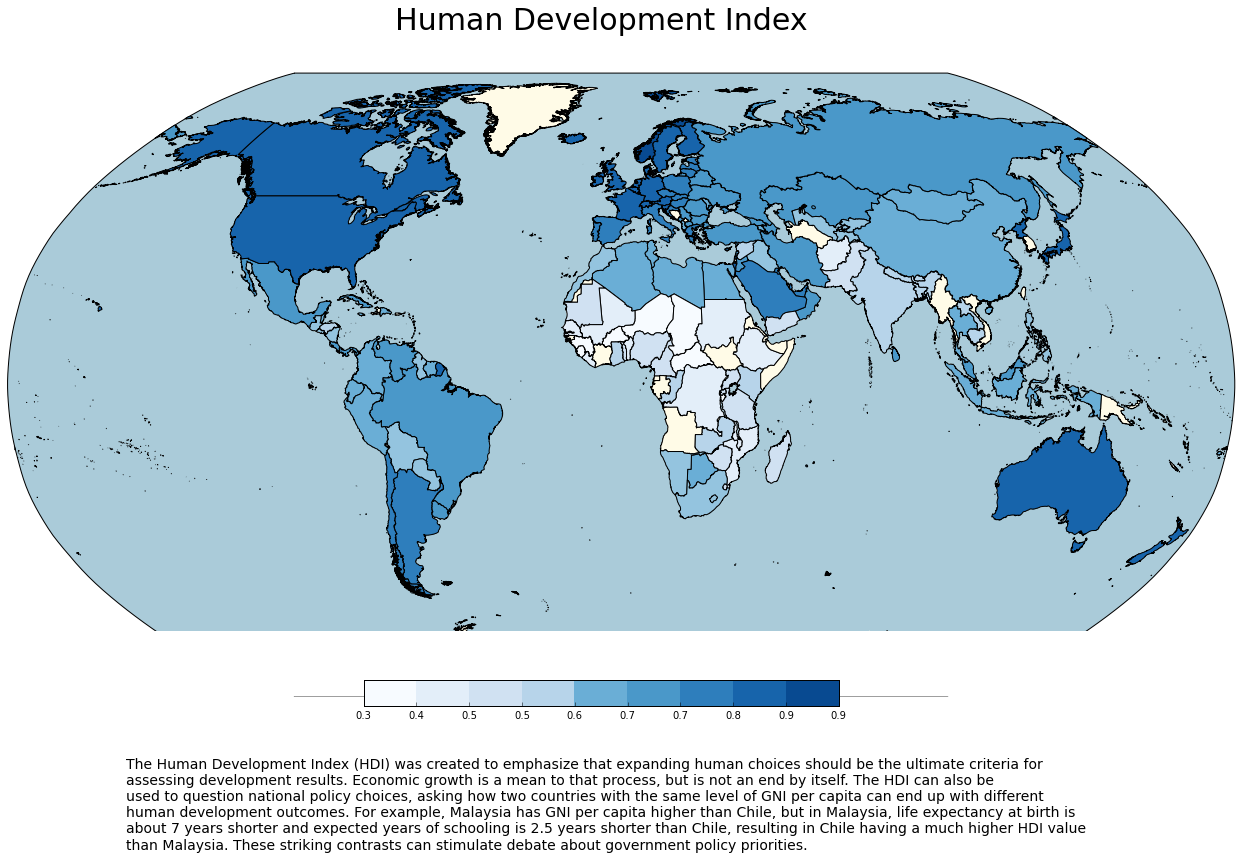

In [58]:
# http://ramiro.org/notebook/basemap-choropleth/

fig = plt.figure(figsize=(22, 12))

ax = fig.add_subplot(111, axisbg='w', frame_on=False)
fig.suptitle("Human Development Index", fontsize=30, y=.95)

m.drawmapboundary(fill_color=WATER_COLOR, zorder=1)
m.fillcontinents(color=CONTINENT_COLOR, lake_color=WATER_COLOR, zorder=1);

# Draw countries
m.readshapefile(PATH_TO_SHAPEFILE, 'countries',
                color='black', linewidth=.2, zorder=2)

for info, shape in zip(m.countries_info, m.countries):

    country_iso_a3 = info.get("ADM0_A3") # ADM0_A3, ISO_A3
    country_name = info.get("NAME")

    if country_iso_a3 in hdi_df.index:
        color = scheme[hdi_df.ix[country_iso_a3]['bin']]
    else:
        color = CONTINENT_COLOR

    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches, zorder=2)
    pc.set_facecolor(color)
    ax.add_collection(pc)
    

# Cover up Antarctica so legend can be placed over it.
ax.axhspan(0, 1000 * 1800, facecolor='w',
           edgecolor='w', zorder=2)

# Draw color legend.
ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)

cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap,
                               ticks=bins, boundaries=bins,
                               orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins]);

# Set the map footer.
plt.annotate(DESCRIPTION, xy=(-1.5, -6.5),
             size=14, xycoords='axes fraction')

# Двумерное представление данных

In [59]:
from sklearn.manifold import TSNE

In [60]:
X = hdi_df[["life_expectancy_at_birth", "expected_years_of_schooling",
        "mean_years_of_schooling", "gni", "gni_rank_minus_hdi_rank"]].as_matrix()
X.shape

(188, 5)

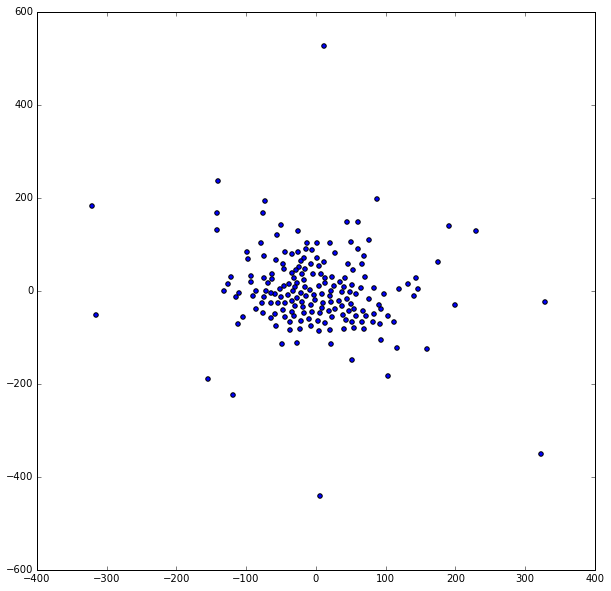

In [61]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
low_dim_X = model.fit_transform(X) 

fig = plt.figure(figsize=(10, 10))
_x, _y = zip(*low_dim_X)
plt.scatter(_x, _y)

In [74]:
def plot_extendet_boxplot(y_df, color="orange"):
    y_df.boxplot()
    x = np.random.normal(i+1, 0.04, len(y_df))
    plt.plot(x, y_df, alpha=0.1, mfc=color, mec='k',
             ms=7, marker="o", linestyle="None")

In [75]:
def plot_boxplot_for_dataframe(df):
    subplots_num = len(df.columns)
    for i, col in enumerate(df.columns):
        plt.subplot(1, subplots_num, (i+1))
        plot_extendet_boxplot(df[[col]])

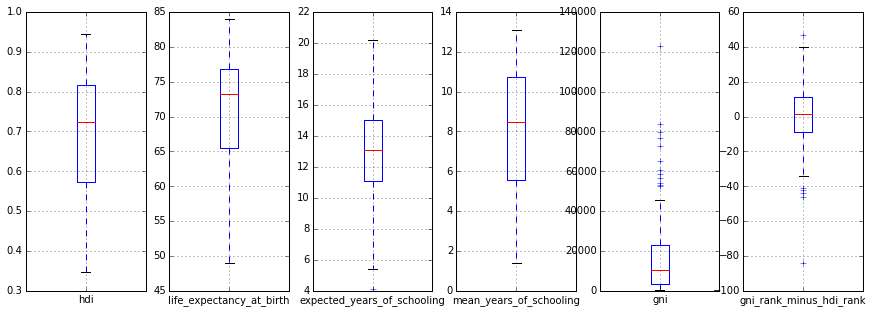

In [76]:
plt.figure(figsize=(15, 5))
plot_boxplot_for_dataframe(hdi_df[["hdi", "life_expectancy_at_birth", "expected_years_of_schooling",
        "mean_years_of_schooling", "gni", "gni_rank_minus_hdi_rank",]])

# Heat Map